In [1]:
# %load ../include/header.py
import numpy as np
import matplotlib.pyplot as plt
from graphenetools import gt
import re,glob,os
from scipy.interpolate import interp1d
from scipy import interpolate
import sys,importlib
from collections import defaultdict
from numpy import pi as π
import dgutils

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
### plot style
plot_style = {'notebook':'../include/notebook.mplstyle','sans':'../include/sans_NC.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['sans'])
figsize = plt.rcParams['figure.figsize']

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# setup a possible custom font path
from matplotlib import font_manager
def what_font_path (filename):
    for p in font_manager.findSystemFonts(fontpaths=None, fontext="ttf"):
        if p.find(filename) != -1:
            return p

font_path,bold_font_path = '.','.'
if 'LOCAL_FONT_PATH' in os.environ:
    font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Light-08.ttf'
    bold_font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Bold-02.ttf'
else:
    # local path (custom)
    font_path = what_font_path('HelveticaNeue-Light-08')
    bold_font_path = what_font_path('HelveticaNeue-Bold-02')

In [3]:
grey = '#a7a7a7'
dgrey = '#303030'

In [4]:
# input data
delta,t,V,Vp = np.genfromtxt('../data/BH_vs_strain.dat',unpack=True,missing_values='N/A')

In [5]:
tinterp = interpolate.CubicSpline(delta,t)
Vinterp = interpolate.CubicSpline(delta,V)
Vpinterp = interpolate.CubicSpline(delta,Vp)
ainterp = interpolate.CubicSpline(delta,np.array(V)/np.array(Vp))

In [6]:
# Define energy list

def gamma(s,a):
    return (s*a - 1)/(a + 1)

def term1(t,mu,s,a):
    return (t + mu/6)

def term2(t,mu,s,a):
    return (t + mu/6)*(t - mu/6 + gamma(s,a))

def term3(t,mu,s,a):
    return 2*t + gamma(s,a)

def e13(t,mu,s,a):
    return (-mu - 3/(a + 1))*16

def e23(t,mu,s,a):
    return (-2*mu + (3*s*a - 6)/(a + 1))*16

def e33(t,mu,s,a):
    return (-3*mu + 9*(s*a - 1)/(a + 1))*16

def e716(t,mu,s,a):
#     return -21*mu + 18*s*a/(a + 1) - 36/(a + 1)
    return -21*mu + 27*(s*a - 1)/(a + 1)

def esf(t,mu,s,a):
    return (-9*(t + mu/6)**2/(2*t + gamma(s,a)))*16

def lst(t,mu,s,a):
    if (term2(t,mu,s,a) > 0 \
        and 1 >= term1(t,mu,s,a)/term3(t,mu,s,a) \
        and term1(t,mu,s,a)/term3(t,mu,s,a) > 0):
        return [e13(t,mu,s,a), e716(t,mu,s,a), e23(t,mu,s,a), e33(t,mu,s,a), esf(t,mu,s,a), 0.0]
    else:
        return [e13(t,mu,s,a), e716(t,mu,s,a), e23(t,mu,s,a), e33(t,mu,s,a), 999999.0, 0.0]

def pref_state(t,mu,s,a):
    return lst(t,mu,s,a).index(min(lst(t,mu,s,a)))

In [7]:
nx = 1000
ny = 1000

delta_new = np.linspace(0, 0.3, nx)

tnew = tinterp(delta_new)   # use interpolation function returned by `interp1d`
Vnew = Vinterp(delta_new)
Vpnew = Vpinterp(delta_new)
anew = ainterp(delta_new)

a_lst = [-x/y if x>=0 else x/y for x, y in zip(Vnew,Vpnew)]
s_lst = [1 if x>=0 else -1 for x in Vnew]
norm = [x-y if x>=0 else -x-y for x, y in zip(Vnew,Vpnew)]

mu_lst = np.linspace(-30,120,ny)
tbar = [x/y for x, y in zip(tnew,norm)]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica Neue


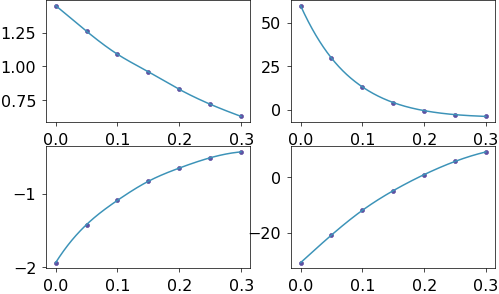

In [8]:
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(delta, t, 'o', delta_new, tnew, '-')
axs[0,1].plot(delta, V, 'o', delta_new, Vnew, '-')
axs[1,0].plot(delta, Vp, 'o', delta_new, Vpnew, '-')
axs[1,1].plot(delta, np.array(V)/np.array(Vp), 'o', delta_new, anew, '-');

# Abstract PD

# a = 33 (0% strain)

In [9]:
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects

def get_cmap(phases):
    colors = {'0.0':'#22b2aa55', '2.0':'#22b2aa99', '3.0':'#22b2aa', '4.0':'coral', '5.0':'#e6e2dc'}
    return mcolors.ListedColormap([colors[str(p)] for p in phases])

def ab_pdmaker (ax,t, mu, data, dt, dmu, VoVp, show_grid=False, grid_scale=1, locate_system=None, 
               labels=None, label_loc=None):
    
    phases = np.unique(data)
    cMap = get_cmap(phases)
    p1 = ax.contourf(t, mu, data, len(phases), vmin = np.min(phases), vmax = np.max(phases), cmap = cMap)

    ax.set_xlabel(r'$t\,/\,\left(|V|+|V^{\prime}|\right)$')
    ax.set_ylabel(r'$\mu\,/\,\left(|V|+|V^{\prime}|\right)$')

    #ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim(0,0.69)
    ax.set_ylim(-7.9,7.9)
    
    if show_grid:
        xgridset = np.arange(0, 0.7, dt)
        ygridset = np.arange(-8, 8, dmu)

        ax.set_xticks(xgridset, minor=True)
        ax.set_yticks(ygridset, minor=True)
        ax.grid(which='minor', color='dodgerblue', linewidth=0.6)
        ax.tick_params(which='minor', bottom=False, left=False)
        
    else:
        rect = patches.Rectangle((0.01, -7.7), dt*grid_scale, dmu*grid_scale, ec=dgrey, fill=False, 
                                 lw=0.35)
        ax.add_patch(rect)
        scale_text = ''
        if grid_scale > 1:
            scale_text = f'{grid_scale}' + r'$\times\,$'
        ax.text(0.015+dt*grid_scale, -7.8, scale_text + 'grid size', va='bottom',ha='left', color=dgrey)
        
    # Add a x to specify the system location
    if locate_system is not None:
        
        ax.annotate("",xy=(locate_system[0],locate_system[1]), xycoords='data',xytext=(0.1,-2.5),
                   arrowprops=dict(arrowstyle="-|>",color='k',lw=0.5,shrinkA=0.02,shrinkB=0.02))
        ax.annotate(r'$^4$He on graphene',xy=(0.05,-2.5), xycoords='data',xytext=(0.05,-2.5),
                   ha='left',va='top' )
        ax.plot(*locate_system, marker='x', color='k', mew=0.5, ms=2)
        
    # Add some possible phase labels
    if labels is not None:
        path_eff = [path_effects.withSimplePatchShadow(offset=(0.05, -0.05), shadow_rgbFace='k', alpha=0.9)]

        for lab,loc in zip(labels,label_loc):
            col='k'
            ax.text(*loc, lab, va='center',ha='left', color=col, path_effects=path_eff)
            
    # add the V/V' label
    ax.text(0.685,7.75, r'$V\,/\,|V^\prime| \simeq $' + f'{VoVp}', va='top',ha='right')

    return ax

In [10]:
def get_pd_data(nx,ny,s,a,delta,V,Vp):
    
    ab_tbar = np.linspace(0,0.7,nx)
    ab_mubar = np.linspace(-8,8,ny)
    ab_data = np.zeros((ny,nx))
    
    ainterp_2 = interpolate.CubicSpline(delta,np.array(V)/np.array(Vp)+a)
    root = ainterp_2.roots()[1]
    sampleV = Vinterp(root)
    sampleVp = Vpinterp(root)
    
    dt = 0.2/(abs(sampleV)+abs(sampleVp))
    dmu = 5/(abs(sampleV)+abs(sampleVp))

    for i in range(nx):
        for j in range(ny):
            ab_data[j,i] = pref_state(ab_tbar[i],ab_mubar[j],s,a)
            
    return ab_tbar, ab_mubar, ab_data, dt, dmu

In [35]:
data_pd = {}

In [36]:
data_pd['a=33'] = get_pd_data(nx,ny,1,np.abs(ainterp(0.0)),delta,V,Vp)
data_pd['a=4'] = get_pd_data(nx,ny,4,1,delta,V,Vp)
data_pd['a=-1'] = get_pd_data(nx,ny,-1,1,delta,V,Vp)
data_pd['a=1'] = get_pd_data(nx,ny,1,1,delta,V,Vp)

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


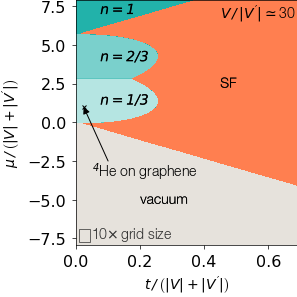

In [41]:
plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    
    fig,ax = plt.subplots(1,1,figsize=(figsize[1],figsize[1]),constrained_layout=True)
    dgutils.fonts.set_custom_font(font_path)
    
    labels=['vacuum','SF',r'$n=1/3$',r'$n=2/3$',r'$n=1$']
    label_loc = [[0.2,-5],[0.45,2.5],[0.075,1.4],[0.075,4.2],[0.075,7.25]]
    ax = ab_pdmaker(ax,*data_pd['a=33'], 30,grid_scale=10,
                   locate_system=[t[0]/(np.abs(V[0]) + np.abs(Vp[0])),1], 
                   labels=labels,label_loc=label_loc)
    fig.savefig('../figures/MFpd_delta_0.00.pdf')

# a = 1

### Find the value of strain where V/V' = -1

δ = 0.183


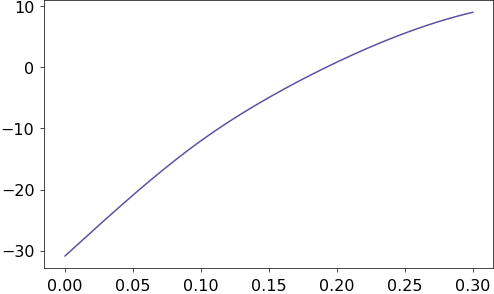

In [42]:
δ = np.linspace(0, 0.3, 10000)
VoVp = ainterp(δ)
plt.plot(δ,VoVp)

idx = np.where(np.abs(VoVp+1) < 1E-2)[0][0]
cδ = δ[idx]
print(f'δ = {δ[idx]:.3f}')

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


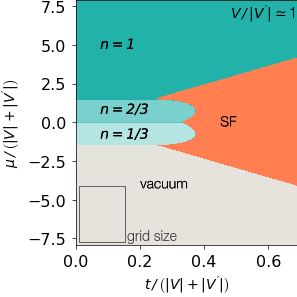

In [43]:
plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    
    fig,ax = plt.subplots(1,1,figsize=(figsize[1],figsize[1]),constrained_layout=True)
    dgutils.fonts.set_custom_font(font_path)
    
    labels=['vacuum','SF',r'$n=1/3$',r'$n=2/3$',r'$n=1$']
    label_loc = [[0.2,-4.0],[0.45,0],[0.075,-0.8],[0.075,0.8],[0.075,5]]
    ax = ab_pdmaker(ax,*data_pd['a=1'],1,labels=labels,label_loc=label_loc)

    fig.savefig(f'../figures/MFpd_delta_{cδ:4.2f}.pdf')

# s = -1, a = 1 (both attractive)

In [44]:
idx = np.where(np.abs(VoVp-1) < 1E-2)[0][0]
cδ = δ[idx]
print(f'δ = {δ[idx]:.3f}')

δ = 0.201


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


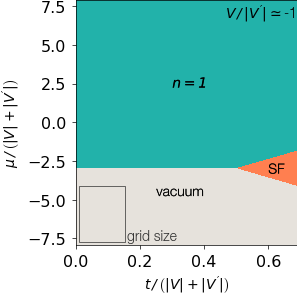

In [45]:
plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    
    fig,ax = plt.subplots(1,1,figsize=(figsize[1],figsize[1]),constrained_layout=True)
    dgutils.fonts.set_custom_font(font_path)
    
    labels=['vacuum','SF',r'$n=1$']
    label_loc = [[0.25,-4.5],[0.6,-3.05],[0.3,2.5]]
    ax = ab_pdmaker(ax,*data_pd['a=-1'],-1,labels=labels,label_loc=label_loc)

    fig.savefig(f'../figures/MFpd_delta_{cδ:4.2f}.pdf')

# Physical PD

In [11]:
mubar = np.zeros((ny,nx))
data = np.zeros((ny,nx))
for i in range(nx):
    for j in range(ny):
        mubar[j,i] = mu_lst[j]/norm[i]

for i in range(nx):
    for j in range(ny):
        data[j,i] = pref_state(tbar[i],mubar[j,i],s_lst[i],a_lst[i])

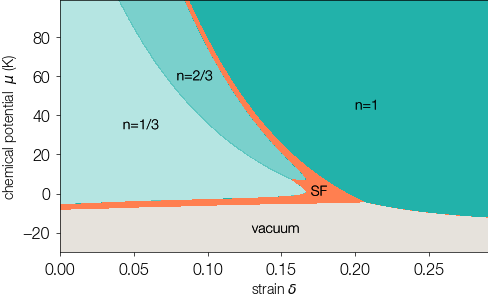

In [19]:
# cMap = mcolors.ListedColormap([
#             'aquamarine', 
#             'turquoise', 
#             'lightseagreen', 
#             'coral', 
#             'snow'])

plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    
    dgutils.fonts.set_custom_font(font_path)

    cMap = get_cmap(np.unique(data))
    fig,ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]),constrained_layout=True)
    p1 = ax.contourf(delta_new, mu_lst, data, 5, vmin = 0, vmax = 5,cmap=cMap)

    ax.set_xlabel(r'strain $\delta$')
    ax.set_ylabel(r'chemical potential  $\mu$ (K)')
    
    ax.set_xlim(0,0.29)
    ax.set_ylim(-30,99)
    
    path_eff = [path_effects.withSimplePatchShadow(offset=(0.05, -0.05), shadow_rgbFace='k', alpha=0.9)]
    
    labels=['vacuum','SF',r'n=1/3',r'n=2/3',r'n=1']
    label_loc = [[0.13,-18],[0.17,1],[0.0425,35],[0.079,60],[0.2,45]]

    for lab,loc in zip(labels,label_loc):
        ax.text(*loc, lab, va='center',ha='left', path_effects=path_eff)
    
    fig.savefig('../figures/mu_delta_phase_diagram.pdf')

## Decorate the Strained Lattice

In [47]:
def get_unit_vec(start,end):
    end = np.array(end)
    start = np.array(start)
    vec = end-start
    length = np.linalg.norm(vec)
    vec /= length
    return vec,length

In [48]:
import matplotlib as mpl
from Bezier import Bezier

# lattice vectors
aₒ = 1.42
a = (aₒ/2)*np.array([[np.sqrt(3),-np.sqrt(3)],[3,3]])

def decorate_graphene(ax):
    im = plt.imread('../figures/V_Vp_He_graphene.png')
    ax.imshow(im,interpolation='none',extent=[-5.15,5.15,-4.5,4.5])

    # V interaction
    start,end = [0,0],[-a[0,0],a[1,0]]
    vec,length = get_unit_vec(start,end)
    V = np.array(dgutils.pypov.generate_linear_path(start + 0.2*length*vec, end - 0.15*length*vec,200))
    Vtext = start + 0.66*vec*length
    Vtext[0] += 0.3

    # V' interaction
    start,end = [-a[0,0],-a[1,0]],[-a[0,0],a[1,0]]
    mid = [-2.5*a[0,0],0]
    vec1,length1 = get_unit_vec(start,mid)
    vec2,length2 = get_unit_vec(mid,end)
    Vptext = mid
    Vptext[0] += 1

    t_points = np.linspace(0, 1, 1000) 
    points = np.array([start + 0.15*length1*vec1,mid,end - 0.15*length2*vec2])
    curve = Bezier.Curve(t_points, points)

    vec,length = get_unit_vec(start,end)

    with mpl.rc_context({'path.sketch': (1.5, 5, 1)}):
        ax.plot(V[:,0],V[:,1], lw=0.5, color=grey)
        ax.plot(curve[:,0],curve[:,1], lw=0.5, color=grey)

    # Add some text labels
    dgutils.fonts.set_custom_font(font_path)
    path_eff = [path_effects.withSimplePatchShadow(offset=(0.1, -0.1), shadow_rgbFace='k', alpha=1.0)]

    ax.text(*Vtext,r'$V$',ha='center',va='center', color=dgrey,
            path_effects=path_eff)
    ax.text(*Vptext,r'$V\prime$',ha='center',va='center', color=dgrey,
            path_effects=path_eff)
    ax.text(1.5*a[0,0],0.3,r'$t$',ha='center',va='center', color=dgrey,
            path_effects=path_eff)
    ax.text(2.12,1.7*a[1,0],r'$a_0(1+\delta)$',ha='center',va='center', color=dgrey,
            path_effects=path_eff, rotation=-30)

    ax.axis('off');
    
    return ax

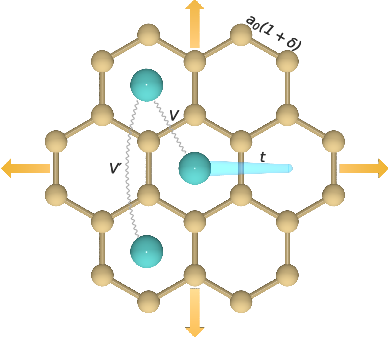

In [49]:
plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    fig,ax = plt.subplots(figsize=((4/5)*figsize[0],(4/5)*figsize[0]),constrained_layout=True)
    dgutils.fonts.set_custom_font(font_path)
    
    ax = decorate_graphene(ax)
    fig.savefig('../figures/biaxial_strain.pdf')

## Create the Combined Figure

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


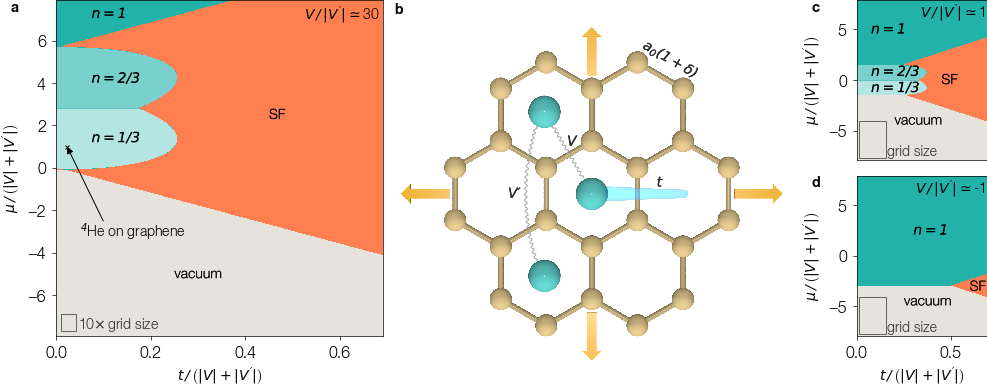

In [50]:
plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    
    dgutils.fonts.set_custom_font(font_path)

    fig = plt.figure(figsize=(2*figsize[0],(4/5)*figsize[0]), constrained_layout=True)
    
    pd0_fig,G_fig,pd_fig = fig.subfigures(nrows=1,ncols=3, width_ratios=[2,2,1])
    ax_pd0 = pd0_fig.subplots(1,1)
    ax_G = G_fig.subplots(1,1)
    ax_pd = pd_fig.subplots(nrows=2,ncols=1)
    
    labels=['vacuum','SF',r'$n=1/3$',r'$n=2/3$',r'$n=1$']
    label_loc = [[0.25,-5],[0.45,2.5],[0.075,1.4],[0.075,4.2],[0.075,7.25]]
    ax_pd0 = ab_pdmaker(ax_pd0,*data_pd['a=33'], 30,grid_scale=10,
                   locate_system=[t[0]/(np.abs(V[0]) + np.abs(Vp[0])),1], 
                   labels=labels,label_loc=label_loc)
    
    ax_G = decorate_graphene(ax_G)
    
    labels=['vacuum','SF',r'$n=1/3$',r'$n=2/3$',r'$n=1$']
    label_loc = [[0.2,-4.0],[0.45,0],[0.075,-0.8],[0.075,0.8],[0.075,5]]
    ax_pd[0] = ab_pdmaker(ax_pd[0],*data_pd['a=1'],1,labels=labels,label_loc=label_loc)
    ax_pd[0].xaxis.set_visible(False)

    
    labels=['vacuum','SF',r'$n=1$']
    label_loc = [[0.25,-4.5],[0.6,-3.05],[0.3,2.5]]
    ax_pd[1] = ab_pdmaker(ax_pd[1],*data_pd['a=-1'],-1,labels=labels,label_loc=label_loc)
    
    # add panel labels
    font_props = dgutils.fonts.get_custom_font_props(bold_font_path)

    ax_pd0.text(-0.14,1.0,'a', ha='left',va='top', transform=ax_pd0.transAxes, fontproperties=font_props) 
    fig.text(2/5,0.98,'b', ha='left',va='top',fontproperties=font_props)

    #ax_G.text(0,1,'b',ha='left',va='top',transform=ax_G.transAxes, fontproperties=font_props)
    for i,lab in enumerate(['c','d']):
        ax_pd[i].text(-0.35,1.0,lab,ha='left',va='top',transform=ax_pd[i].transAxes, fontproperties=font_props)
    
    fig.savefig('../figures/mf_phase_diagrams.pdf')
       

In [24]:
tinterp(0.183)/(np.abs(Vinterp(0.183))+np.abs(Vpinterp(0.183)))

tinterp(0.157)/(np.abs(Vinterp(0.157))+np.abs(Vpinterp(0.157)))



0.23306708782271637